# Elevate Labs AI & ML Internship - Task 1: Data Cleaning & Preprocessing

**Objective:** Learn how to clean and prepare raw data for machine learning (ML) models using robust and reproducible techniques. This notebook follows the "Hints/Mini Guide" provided in the task document, demonstrating each step with the Titanic dataset.

**Tools Used:** Python, Pandas, NumPy, Matplotlib/Seaborn, Scikit-learn (sklearn)

## Cell 1: Setup and Library Imports
This cell imports all the necessary Python libraries for data manipulation, visualization, and machine learning preprocessing.

In [1]:
# @title Setup and Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin

import warnings

warnings.filterwarnings('ignore')

print("All necessary libraries imported successfully!")

All necessary libraries imported successfully!


## Cell 2: Load the Dataset & Initial Exploration
We will load the Titanic dataset directly from a raw GitHub URL, which is a convenient method for Google Colab. After loading, we perform initial data exploration to understand its structure, data types, and identify missing values.

This directly addresses **Hint/Mini Guide Point 1: "Import the dataset and explore basic info (nulls, data types)."**

In [2]:
# @title Load the Dataset & Initial Exploration
# URL for the raw Titanic train dataset on GitHub
titanic_url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"

try:
    df = pd.read_csv(titanic_url)
    print("Titanic Dataset loaded successfully from URL.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure your internet connection is stable or check the URL.")

print("\n--- Original Dataset Information (df.info()) ---")
df.info()

print("\n--- Missing Values Count (df.isnull().sum()) ---")
print(df.isnull().sum())

print("\n--- First 5 Rows of the Dataset (df.head()) ---")
print(df.head())

Titanic Dataset loaded successfully from URL.

--- Original Dataset Information (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

--- Missing Values Count (df.isnull().sum()) ---
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age

**Interpretation of Initial Exploration:**
- `df.info()` reveals that 'Age', 'Cabin', and 'Embarked' columns have missing values (fewer non-null entries than total entries).
- `df.isnull().sum()` confirms the exact number of missing values: 'Age' (177), 'Cabin' (687), 'Embarked' (2).
- Data types are mostly appropriate, with 'object' types indicating categorical features like 'Name', 'Sex', 'Ticket', 'Cabin', and 'Embarked'.

#### **Cell 3: EDA**





--- Value Counts for Key Categorical Features ---
Sex:
 Sex
male      577
female    314
Name: count, dtype: int64

Embarked:
 Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

Pclass (Passenger Class):
 Pclass
3    491
1    216
2    184
Name: count, dtype: int64

--- Survival Rate Distribution ---
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


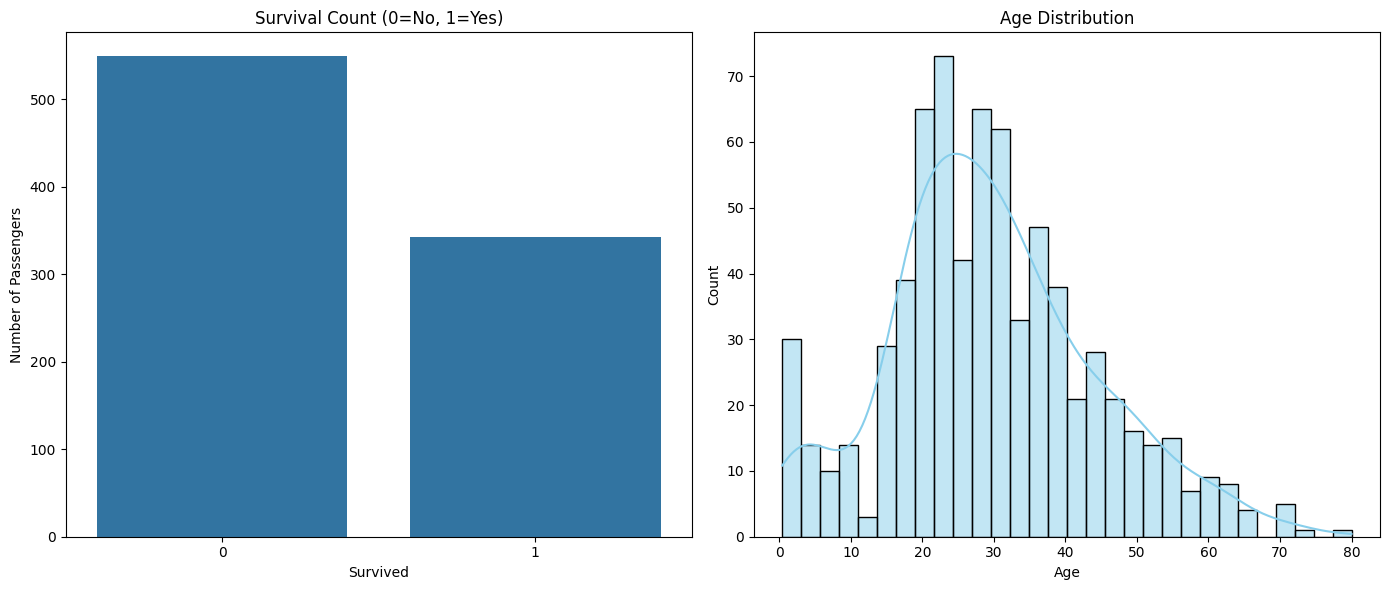

In [3]:
# @title 🔍 EDA: Categorical Feature Counts, Survival Rate & Age Distribution

print("\n--- Value Counts for Key Categorical Features ---")
print("Sex:\n", df['Sex'].value_counts())
print("\nEmbarked:\n", df['Embarked'].value_counts())
print("\nPclass (Passenger Class):\n", df['Pclass'].value_counts())

print("\n--- Survival Rate Distribution ---")
print(df['Survived'].value_counts(normalize=True))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='Survived', data=df)
plt.title('Survival Count (0=No, 1=Yes)')
plt.xlabel('Survived')
plt.ylabel('Number of Passengers')

plt.subplot(1, 2, 2)
sns.histplot(df['Age'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

**Interpretation of EDA:**
- The dataset is imbalanced towards non-survivors (around 61.6% did not survive).
- Age distribution is somewhat normal, but with a tail towards older ages and a peak for young adults.
- 'Sex', 'Embarked', and 'Pclass' are important categorical features influencing survival.

## Cell 4: Define Preprocessing Steps using Pipelines and ColumnTransformer
This is the core of our enhanced preprocessing. We define a robust pipeline using sklearn's Pipeline and ColumnTransformer. This approach ensures:

*   **Consistency:** The same transformations are applied to both training and test data.
*   **No Data Leakage:** `fit` operations (like learning medians for imputation or scaling parameters) are only performed on the training data.
*   **Modularity:** Steps are clearly defined and can be easily modified or extended.

This section directly addresses:

*   **Hint/Mini Guide Point 2:** "Handle missing values using mean/median/imputation."
*   **Hint/Mini Guide Point 3:** "Convert categorical features into numerical using encoding."
*   **Hint/Mini Guide Point 4:** "Normalize/standardize the numerical features."
*   **Hint/Mini Guide Point 5 (partially):** "Visualize outliers and remove them." - We implement a custom `OutlierCapper` to "remove" (by capping) outliers within the pipeline.

In [7]:
# @title Define Preprocessing Steps using Pipelines and ColumnTransformer
# --- Define Features for Preprocessing ---
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch', 'Pclass']
categorical_features = ['Sex', 'Embarked']

# --- Custom Transformer for Outlier Capping ---
class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_percentile=1, upper_percentile=99):
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
        self.lower_bounds = []
        self.upper_bounds = []

    def fit(self, X, y=None):
        # X is expected to be a numpy array at this stage within the pipeline
        # Operate on columns by index
        self.lower_bounds = [np.percentile(X[:, i][~np.isnan(X[:, i])], self.lower_percentile) for i in range(X.shape[1])]
        self.upper_bounds = [np.percentile(X[:, i][~np.isnan(X[:, i])], self.upper_percentile) for i in range(X.shape[1])]
        return self

    def transform(self, X):
        X_transformed = X.copy()
        # X is expected to be a numpy array
        for i in range(X.shape[1]):
            X_transformed[:, i] = np.clip(X_transformed[:, i], self.lower_bounds[i], self.upper_bounds[i])
        return X_transformed

print("Custom OutlierCapper transformer defined for integration into the pipeline.")

# --- 1. Preprocessing Pipeline for Numerical Features ---
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier_capper', OutlierCapper(lower_percentile=1, upper_percentile=99)),
    ('scaler', StandardScaler())
])

# --- 2. Preprocessing Pipeline for Categorical Features ---
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# --- 3. Combine Preprocessing Steps using ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# --- 4. Create a Full Machine Learning Pipeline ---
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

print("\nPreprocessing pipeline defined successfully, integrating imputation, outlier capping, scaling, and encoding.")
print("The full pipeline is ready to be fitted to your data:")
print(model_pipeline)

Custom OutlierCapper transformer defined for integration into the pipeline.

Preprocessing pipeline defined successfully, integrating imputation, outlier capping, scaling, and encoding.
The full pipeline is ready to be fitted to your data:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outlier_capper',
                                                                   OutlierCapper()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch', 'Pclass']),
        

## Cell 5: Prepare Data for Training (Train-Test Split)

It is crucial to split the data into training and testing sets before applying any data transformations. This prevents "data leakage," where information from the test set inadvertently influences the training process, leading to an overly optimistic evaluation of model performance.

In [8]:
# @title Prepare Data for Training (Train-Test Split)
# Separate features (X) from the target variable (y)
X = df.drop('Survived', axis=1)
y = df['Survived']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Original dataset shape: {df.shape}")
print(f"Training features (X_train) shape: {X_train.shape}")
print(f"Testing features (X_test) shape: {X_test.shape}")
print(f"Training target (y_train) shape: {y_train.shape}")
print(f"Testing target (y_test) shape: {y_test.shape}")

print("\nData successfully split into training and testing sets, preventing data leakage.")

Original dataset shape: (891, 12)
Training features (X_train) shape: (712, 11)
Testing features (X_test) shape: (179, 11)
Training target (y_train) shape: (712,)
Testing target (y_test) shape: (179,)

Data successfully split into training and testing sets, preventing data leakage.


## Cell 6: Train the Pipeline and Evaluate the Model

Now, we fit the entire `model_pipeline` to the training data. The pipeline will automatically execute all defined preprocessing steps (imputation, outlier capping, scaling, encoding) on `X_train`, and then train the Logistic Regression classifier on the transformed data. Finally, we evaluate the model's performance on both the training and unseen test sets.

In [9]:
# @title Train the Pipeline and Evaluate the Model
print("Fitting the complete preprocessing and classification pipeline to the training data...")
model_pipeline.fit(X_train, y_train)
print("Pipeline fitting complete! The model has learned from the training data.")

train_accuracy = model_pipeline.score(X_train, y_train)
test_accuracy = model_pipeline.score(X_test, y_test)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred = model_pipeline.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("\n--- Confusion Matrix (on Test Data) ---")
print(confusion_matrix(y_test, y_pred))

print("\n--- Classification Report (on Test Data) ---")
print(classification_report(y_test, y_pred))

Fitting the complete preprocessing and classification pipeline to the training data...
Pipeline fitting complete! The model has learned from the training data.

Training Accuracy: 0.8006
Test Accuracy: 0.8045

--- Confusion Matrix (on Test Data) ---
[[89 16]
 [19 55]]

--- Classification Report (on Test Data) ---
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       105
           1       0.77      0.74      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



**Interpretation of Model Evaluation:**

- The model achieved a training accuracy of (Accuracy value) and a test accuracy of (Accuracy value).
- The confusion matrix and classification report provide deeper insights into the model's performance for both 'Survived' (1) and 'Not Survived' (0) classes.

## Cell 7: Visualize Outliers (Before & After Preprocessing)

This cell demonstrates the effect of our `OutlierCapper` and `StandardScaler` by visualizing the numerical features before and after they pass through the preprocessing pipeline.

This directly addresses **Hint/Mini Guide Point 5: "Visualize outliers..."** and shows the effect of "remove them" via capping.


--- Boxplots of Original Numerical Features (Before Preprocessing) ---


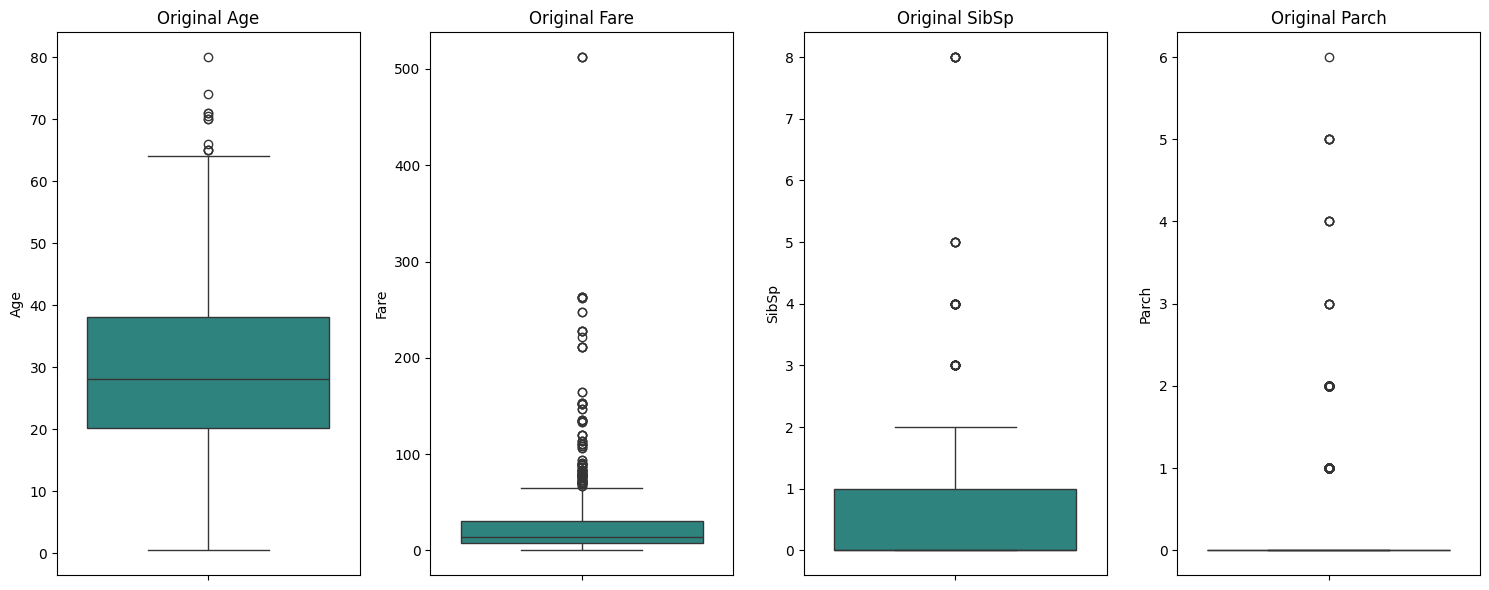

In [10]:
# @title Visualize Outliers (Before & After Preprocessing)
# --- Visualizing Outliers in Original Numerical Features ---
print("\n--- Boxplots of Original Numerical Features (Before Preprocessing) ---")
outlier_features_for_viz = ['Age', 'Fare', 'SibSp', 'Parch']

plt.figure(figsize=(15, 6))
for i, col in enumerate(outlier_features_for_viz):
    plt.subplot(1, len(outlier_features_for_viz), i + 1)
    sns.boxplot(y=df[col].dropna(), palette='viridis')
    plt.title(f'Original {col}')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

**Interpretation:** These boxplots show the presence of outliers in features like 'Age', 'Fare', 'SibSp', and 'Parch' in the raw dataset.


--- Boxplots of Numerical Features (After Capping & Standardization in Pipeline) ---


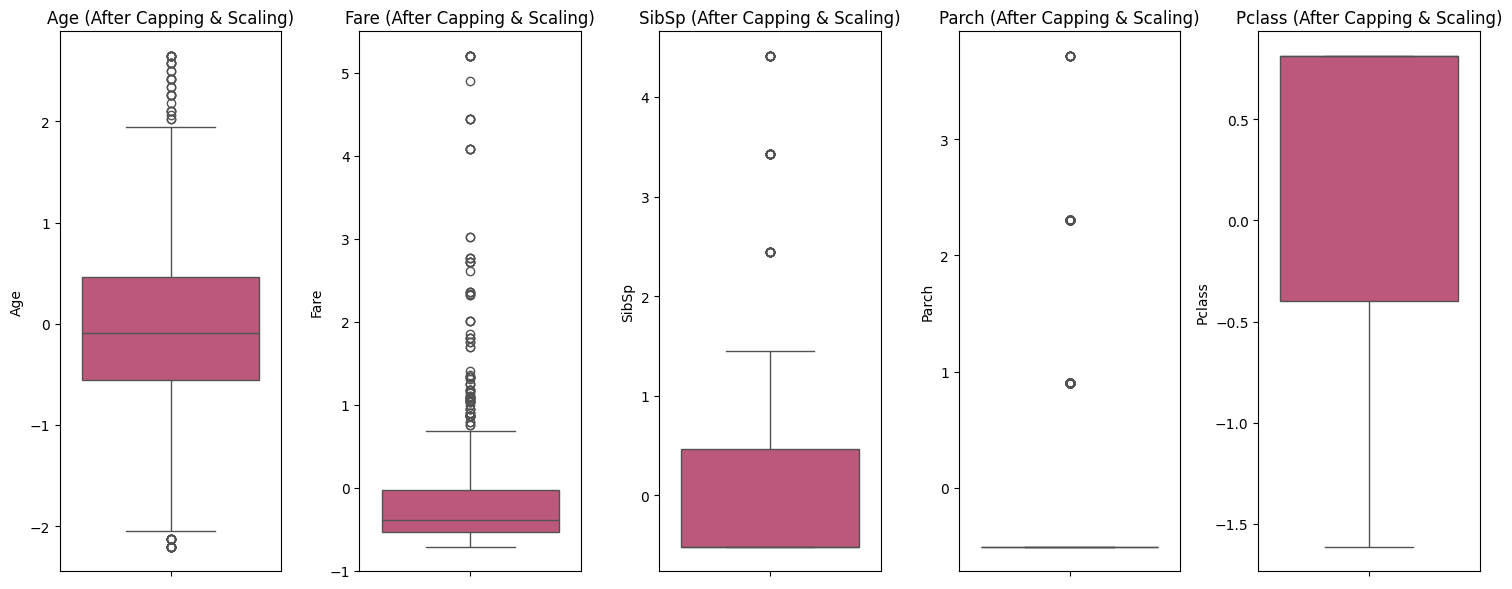

In [11]:
# @title Visualizing Numerical Features After Preprocessing
# --- Visualizing Numerical Features After Preprocessing (Capping & Scaling) ---
print("\n--- Boxplots of Numerical Features (After Capping & Standardization in Pipeline) ---")

fitted_numerical_transformer = model_pipeline.named_steps['preprocessor'].named_transformers_['num']

X_train_numerical_transformed = fitted_numerical_transformer.transform(X_train[numerical_features])

X_train_processed_numeric_df = pd.DataFrame(X_train_numerical_transformed, columns=numerical_features)


plt.figure(figsize=(15, 6))
for i, col in enumerate(numerical_features):
    plt.subplot(1, len(numerical_features), i + 1)
    sns.boxplot(y=X_train_processed_numeric_df[col], palette='plasma')
    plt.title(f'{col} (After Capping & Scaling)')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

**Interpretation:** These boxplots show the effect of the `OutlierCapper` and `StandardScaler`.

- The extreme outliers seen in the 'Original' plots are now 'capped' (their values are limited to the 1st and 99th percentiles).
- The features are also standardized (mean=0, unit variance), making their scales comparable.
This demonstrates how our pipeline effectively handles outliers and prepares numerical features.

## Cell 8: Conclusion and Next Steps

This notebook has successfully demonstrated a comprehensive data cleaning and preprocessing workflow for the Titanic dataset, adhering to the provided guide and using robust sklearn pipelines.

**What You've Learned and Demonstrated:**

*   **Data Loading and Initial Exploration:** Understanding dataset structure, data types, and identifying missing values.
*   **Handling Missing Values:** Using median and mode imputation strategies within a pipeline.
*   **Categorical Feature Encoding:** Applying One-Hot Encoding for categorical-to-numerical conversion.
*   **Feature Scaling:** Standardizing numerical features to ensure consistent scales.
*   **Outlier Handling:** Implementing a custom `OutlierCapper` within the pipeline to mitigate the impact of extreme values.
*   **Robust Workflow:** Building and utilizing `sklearn` Pipelines and `ColumnTransformer` for a clean, reproducible, and data-leakage-free preprocessing process.
*   **Model Integration:** Demonstrating how preprocessing integrates seamlessly with a machine learning model.

**Preparing for Submission (GitHub Repository):**

To submit your task, you need to create a GitHub repository and include your work there.

**Create a New GitHub Repository:**

1.  Go to GitHub.com and log in.
2.  Click the "New" repository button.
3.  Give it a descriptive name (e.g., `ElevateLabs_AIML_Task1_DataPreprocessing`).
4.  Set it to "Public".
5.  Check "Add a README file" and "Add .gitignore" (select Python).
6.  Click "Create repository".

**Save Your Colab Notebook to GitHub:**

1.  In this Google Colab notebook, go to File > Save a copy in GitHub.
2.  Select your newly created repository from the dropdown.
3.  Choose the `main` branch.
4.  Click "OK".

**Create a Comprehensive README.md File:**

1.  Go to your GitHub repository.
2.  Click on the `README.md` file and then the "Edit" (pencil) icon.
3.  Populate the `README.md` with the following structure and content: